# **Adaptive Quantitative Trading with Imitative Recurrent Deterministic Policy Gradient**
*Anonymous authors*

This notebok contains the demo of the report "Adaptive Quantitative Trading with Imitative Recurrent Deterministic Policy Gradient" by Anonymous authors.

## **Importing Libraries**

The required libraries to run this notebook and all other python files are found in `requirements.txt`. You can install by uncommenting the cell below:

In [ ]:
# !pip install -r requirements.txt

Here we import the ones needed for this demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import Image, display

import os

from scripts.Agent import iRDPGAgent
from scripts.Env import POMDPTEnv

from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Setup**

Given the intricate nature of the setting, we needed to create a custom environment, based on the gym-trading-env. It can be found in `scripts/Env.py`, together with the helper functions to compute expert actions. The full agent, composed of the intial embedding GRU, actor, critic, and target networks, is implemented in `scripts/Agent.py`. Finally, the Prioritized Experience Replay Buffer is implemented in `scripts/PERBuffer.py`, together with the Episode class.

The data is retrieved using the `scripts/data_retrieval.py` script, which downloads the data from Alpaca Markets and stores it in a local folder. The preprocessing is done by the environment when it is created. When downloading the data, we select the minute-bar data from a specific interval, during the NSDQ opening hours (9:30-16:00 NYC time). 

*N.B. You need a `.env` file containing your API KEY and SECRET KEY in order to download the data with our script. For privacy reasons the ones of the authors are not provided.*

For this demo, the models are trained on one month of data, namely from 2024-02-01 to 2024-02-29 (included). For time reasons, we provide the weights of the models, which can be found in `models/demo/checkpoint`. You can train the models by running the `train.py` file. Beware that on one NVIDIA GeForce RTX 3090 the training takes around 1 minute per epoch with a batch size of 32, and we train for 100 epochs. 

### **Baseline**

As expalined in the report, we use the Dual Trust strategy as demonstration episodes for the agent. For this reason, we take the performance of this strategy as a baseline for our model. Since our model is trained on one month, we use the startegy on the same period. 

Some strategy parameters (window size, k1, k2) are hyperparameters, which can be optimized. Feel free to change them and see how the performance changes. The other values are usually takan as default for the market. 

In [2]:
df = pd.read_csv('data/train_one_month.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df['date'] = df.index.date

# --- Define Strategy Parameters ---
window_size = 3
k1 = 0.5
k2 = 0.5
initial_balance = 1_000
transaction_cost = 2.3e-5
slippage = 0.2  # Price adjustment on entry/exit
risk_free_rate = 0.02  # Annual risk-free rate

# --- Compute Daily Summary and Dual Thrust Lines ---
daily_df = df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})
daily_df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)

daily_df['HH'] = daily_df['high'].rolling(window=window_size).max()
daily_df['HC'] = daily_df['close'].rolling(window=window_size).max()
daily_df['LC'] = daily_df['close'].rolling(window=window_size).min()
daily_df['LL'] = daily_df['low'].rolling(window=window_size).min()

daily_df['Range'] = np.maximum(daily_df['HH'] - daily_df['LC'],
                                 daily_df['HC'] - daily_df['LL'])
daily_df['BuyLine'] = daily_df['open'] + k1 * daily_df['Range']
daily_df['SellLine'] = daily_df['open'] - k2 * daily_df['Range']

df = df.merge(daily_df[['BuyLine', 'SellLine']], left_on='date', right_index=True, how='left')
df['BuyLine'] = df['BuyLine'].ffill()
df['SellLine'] = df['SellLine'].ffill()

df.reset_index(inplace=True)


In [3]:
# --- Backtest Setup ---
balance = initial_balance
balances = []   
minute_returns = [] 
position = 0        # 0 = hold, 1 = long, -1 = short
entry_price = np.nan


buy_points = []
sell_points = []
# --- Backtest Loop ---
for i in range(len(df)):
    row = df.loc[i]
    current_date = row['date']
    price_open = row['open']
    price_close = row['close']
    
    if i < len(df) - 1:
        next_date = df.loc[i+1, 'date']
        end_of_day = (current_date != next_date)
    else:
        end_of_day = True

    # --- Determine the Trade Signal Based on the Open Price ---
    if price_open > row['BuyLine']:
        new_signal = 1
    elif price_open < row['SellLine']:
        new_signal = -1
    else:
        new_signal = position  # Hold current position

    if end_of_day:
        new_signal = 0

    # --- Trade Execution ---
    if new_signal != position:
        if position != 0:
            if end_of_day:
                if position == 1:
                    effective_exit_price = price_close - slippage
                    # sell signal on the plot
                    sell_points.append((row['timestamp'], effective_exit_price))
                    pnl_exit = (effective_exit_price - entry_price) * position - transaction_cost * effective_exit_price
                else:
                    effective_exit_price = price_close + slippage
                    # buy signal on the plot
                    buy_points.append((row['timestamp'], effective_exit_price))
                    pnl_exit = (entry_price - effective_exit_price) * abs(position) - transaction_cost * effective_exit_price
            else:
                if position == 1:
                    effective_exit_price = price_open - slippage
                    sell_points.append((row['timestamp'], effective_exit_price))
                    pnl_exit = (effective_exit_price - entry_price) * position - transaction_cost * effective_exit_price
                else:
                    effective_exit_price = price_open + slippage
                    buy_points.append((row['timestamp'], effective_exit_price))
                    pnl_exit = (entry_price - effective_exit_price) * abs(position) - transaction_cost * effective_exit_price
            balance += pnl_exit
            position = 0  # reset the position
            entry_price = np.nan

        # Enter a new position if the new signal is nonzero
        if new_signal != 0:
            if new_signal == 1:
                effective_entry_price = price_open + slippage
                buy_points.append((row['timestamp'], effective_entry_price))
            else:
                effective_entry_price = price_open - slippage
                sell_points.append((row['timestamp'], effective_entry_price))
            entry_price = effective_entry_price
            position = new_signal

    # --- Compute PnL for the Minute ---
    if position == 1:
        pnl = (price_close - price_open)
    elif position == -1:
        pnl = (price_open - price_close)
    else:
        pnl = 0

    balance += pnl
    minute_ret = pnl / balance if balance != 0 else 0
    minute_returns.append(minute_ret)
    balances.append(balance)

# --- Performance Metrics ---
total_return = (balance - initial_balance) / initial_balance * 100
avg_minute_return = np.mean(minute_returns) * 100
volatility = np.std(minute_returns) * 100

# Annualize Sharpe Ratio from minute returns
trading_minutes_per_year = 252 * 390  # Typical number of trading minutes per year
minute_risk_free_rate = risk_free_rate / trading_minutes_per_year
excess_minute_returns = np.array(minute_returns) - minute_risk_free_rate
sharpe_ratio = (np.mean(excess_minute_returns) / (np.std(minute_returns) if np.std(minute_returns) else 1)) * np.sqrt(trading_minutes_per_year)

balances_array = np.array(balances)
peak_balance = np.maximum.accumulate(balances_array)
drawdowns = (balances_array - peak_balance) / peak_balance
max_drawdown = np.min(drawdowns) * 100
print(f"Initial Balance: {initial_balance:.2f}")
print(f"Final Balance: {balance:.2f}")
print(f"Total Return: {total_return:.4f}%")
print(f"Average Minute Return: {avg_minute_return:.6f}%")
print(f"Minute Return Volatility: {volatility:.6f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Initial Balance: 1000.00
Final Balance: 997.66
Total Return: -0.2343%
Average Minute Return: 0.000006%
Minute Return Volatility: 0.002149%
Sharpe Ratio: -2.10
Maximum Drawdown: -0.34%


As we can the performance of the strategy is not optimal, as we are loosing money (only 3 euros in one month). The strategy is stable enough to be a baseline for our model, which is encouraged to explore.

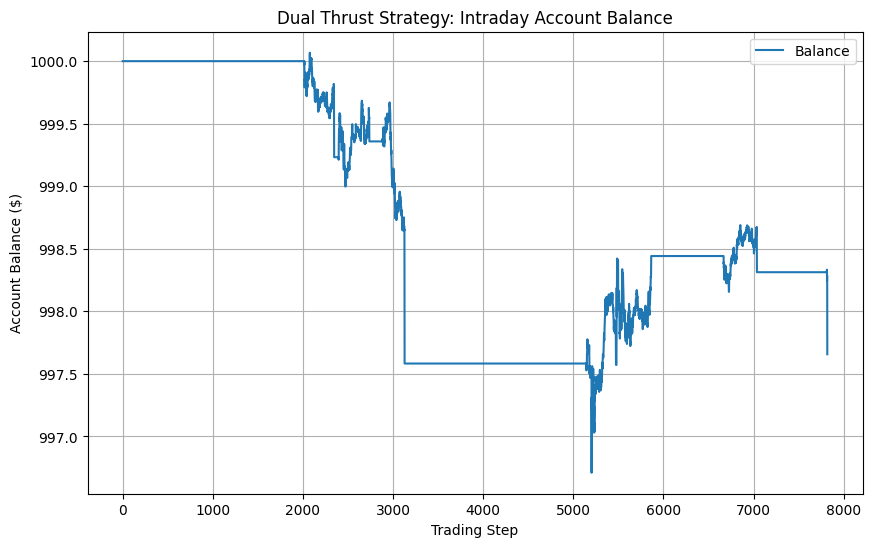

In [4]:
plt.figure(figsize=(10,6))
plt.plot(balances, label="Balance")
plt.title("Dual Thrust Strategy: Intraday Account Balance")
plt.xlabel("Trading Step")
plt.ylabel("Account Balance ($)")
plt.legend()
plt.grid(True)
plt.show()

In this figure we can see the movement of the balance over the month. The first holding line is due to the window size, which leaves the first *n* days without buy and sell lines, and thus signals. 

## **Model Evaluation**

Now, we will evaluate our trained model. For the purpose of the demo, we trained on 100 epochs. Let's start by defining the model loader.

In [5]:
def load_model(agent, filename="trained_irdpg.pth"):
    checkpoint = torch.load(filename, map_location=agent.device)

    agent.actor_gru.load_state_dict(checkpoint["actor_gru"])
    agent.actor_fc.load_state_dict(checkpoint["actor_fc"])
    agent.critic_gru.load_state_dict(checkpoint["critic_gru"])
    agent.critic_fc.load_state_dict(checkpoint["critic_fc"])
    agent.target_actor.load_state_dict(checkpoint["target_actor_gru"])
    agent.target_actor_fc.load_state_dict(checkpoint["target_actor_fc"])
    agent.target_critic.load_state_dict(checkpoint["target_critic_gru"])
    agent.target_critic_fc.load_state_dict(checkpoint["target_critic_fc"])

    return agent

You can use whatever dataset you want for the evaluation. In the `data/` folder we provide the one month, three months, six months, and the full year. Moreover, we do the evaluation on an unseen month, i.e. March 2023. For time constraints, we runt the evaluation loop only on the first five days. 

In [6]:
df = pd.read_csv('data/evaluate_one_month.csv')
df = df[:390*5]

In [7]:
env = POMDPTEnv(df, window_size=1) # Since we are working with few days, we use a window size of 1
agent = iRDPGAgent(obs_dim=env.observation_space.shape[0], device=device)

In [10]:
def evaluate(agent, env, model_path, images_path, num_episodes=10, risk_free_rate=0.0, scaling_factor=None):
    """
    Evaluate the RL agent on the trading environment and compute performance metrics.
    
    Parameters:
        agent: The RL agent instance.
        env: The trading environment.
        model_path: Path to the saved model checkpoint.
        images_path: Directory to save evaluation plots.
        num_episodes: Number of evaluation episodes.
        risk_free_rate: Annual risk-free rate (default 0.0). 
                        Used to compute the per-period risk-free rate for excess returns.
        scaling_factor: Scaling factor for Sharpe ratio. Defaults to 252 for daily returns. 
                        (e.g., use 252*390 for minute-level returns.)
    
    Returns:
        metrics: A dictionary with lists for each metric across episodes.
        report: A dictionary with aggregated metrics (averaged over episodes, formatted as strings).
        
    Notes:
        - The risk_free_rate is divided by the scaling_factor to compute the per-period risk-free rate,
          which is then subtracted from the returns to compute the excess returns for the Sharpe ratio.
        - The action_distribution metric is computed by converting the continuous action outputs into discrete 
          decisions (long if the first component is >= the second; otherwise, short). These counts are stored 
          per episode and later averaged for a plot.
    """
    import os, numpy as np, matplotlib.pyplot as plt, torch
    from tqdm import trange

    os.makedirs(images_path, exist_ok=True)

    # Load the model and set to evaluation mode.
    agent = load_model(agent, model_path)
    agent.eval()

    metrics = {
        'cumulative_returns': [],
        'annualized_sharpe': [],
        'max_drawdowns': [],
        'win_rate': [],
        'profit_factor': [],
        'num_trades': [],
        'action_distribution': [],  # This will store a dict per episode with keys 'long' and 'short'
        'portfolio_values': []
    }

    if scaling_factor is None:
        scaling_factor = 252*390  # Default to minute-level returns

    # Evaluate over the specified number of episodes.
    for ep_idx in trange(num_episodes, desc="Evaluating Episodes"):
        obs = env.reset()
        h_actor = None
        done = False

        # Initialize episode tracking variables.
        portfolio = [env.initial_balance]  # Portfolio value time series.
        actions = []                       # Raw actions from agent.
        trade_returns = []                 # Returns computed from changes in balance.
        current_balance = env.initial_balance
        prev_position = env.position       # To detect when a trade occurs.
        num_trades = 0

        while not done:
            # Get previous action if exists.
            prev_action = actions[-1] if actions else None
            
            # Get the agent's action. The act() method returns a tensor.
            with torch.no_grad():
                action_tensor, h_actor = agent.act(obs, prev_action, h_actor)
            
            # Squeeze all singleton dimensions so that action has shape (2,).
            action = action_tensor
            actions.append(action)
            
            # Execute the action in the environment.
            next_obs, reward, done, _ = env.step(action)
            new_balance = env.balance
            trade_return = new_balance - current_balance
            trade_returns.append(trade_return)
            portfolio.append(new_balance)

            # Count a trade if the agent's position changes.
            if env.position != prev_position:
                num_trades += 1
            prev_position = env.position
            current_balance = new_balance
            obs = next_obs

        # Convert tracking lists to numpy arrays.
        portfolio = np.array(portfolio)
        returns = np.array(trade_returns)

        # Compute cumulative return (%)
        cumulative_return = (portfolio[-1] / portfolio[0] - 1) * 100

        # Compute Annualized Sharpe Ratio.
        # Compute per-period risk-free rate and subtract from returns to obtain excess returns.
        if len(returns) > 1 and np.std(returns) > 0:
            per_period_rf = risk_free_rate / scaling_factor
            excess_returns = returns - per_period_rf
            sharpe = (np.mean(excess_returns) / np.std(excess_returns)) * np.sqrt(scaling_factor)
        else:
            sharpe = 0.0

        # Compute Maximum Drawdown (%)
        peak = np.maximum.accumulate(portfolio)
        drawdown = (peak - portfolio) / peak
        max_drawdown = np.max(drawdown) * 100

        # Compute win rate and profit factor based on trade returns.
        wins = returns[returns > 0]
        losses = returns[returns < 0]
        win_rate = (len(wins) / len(returns)) * 100 if len(returns) > 0 else 0.0
        profit_factor = (np.sum(wins) / np.abs(np.sum(losses))) if np.abs(np.sum(losses)) > 0 else np.inf

        # Convert continuous action outputs into discrete decisions:
        # Define long if the first component is >= second component, otherwise short.
        discrete_actions = [1 if a[0] >= a[1] else -1 for a in actions]
        action_dist = {'long': discrete_actions.count(1), 'short': discrete_actions.count(-1)}

        # Store metrics for the episode.
        metrics['cumulative_returns'].append(cumulative_return)
        metrics['annualized_sharpe'].append(sharpe)
        metrics['max_drawdowns'].append(max_drawdown)
        metrics['win_rate'].append(win_rate)
        metrics['profit_factor'].append(profit_factor)
        metrics['num_trades'].append(num_trades)
        metrics['action_distribution'].append(action_dist)
        metrics['portfolio_values'].append(portfolio)

        # Save plots for this episode.
        plt.figure(figsize=(10, 6))
        plt.plot(portfolio, label='Portfolio Value')
        plt.title(f'Episode {ep_idx+1}: Portfolio Value Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(images_path, f'portfolio_episode_{ep_idx+1}.png'))
        plt.close()

        cum_returns_ts = (portfolio - portfolio[0]) / portfolio[0] * 100
        plt.figure(figsize=(10, 6))
        plt.plot(cum_returns_ts, label='Cumulative Return (%)')
        plt.title(f'Episode {ep_idx+1}: Cumulative Returns Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(images_path, f'cumulative_returns_episode_{ep_idx+1}.png'))
        plt.close()

    # Generate aggregated report (averaged across episodes) as formatted strings.
    report = {
        'cumulative_return (%)': f"{np.mean(metrics['cumulative_returns']):.2f}",
        'sharpe_ratio': f"{np.nanmean(metrics['annualized_sharpe']):.2f}",
        'max_drawdown (%)': f"{np.mean(metrics['max_drawdowns']):.2f}",
        'win_rate (%)': f"{np.mean(metrics['win_rate']):.2f}",
        'profit_factor': f"{np.mean(metrics['profit_factor']):.2f}",
        'num_trades': f"{np.mean(metrics['num_trades']):.1f}"
    }

    return metrics, report

def plot_action_distribution(action_distributions, images_path):
    """
    Plot the average action distribution over episodes.
    
    Parameters:
        action_distributions: A list of dictionaries containing action counts for each episode,
                              where each dictionary has keys 'long' and 'short'.
        images_path: Directory to save the plot.
    """
    import os, numpy as np, matplotlib.pyplot as plt
    # Convert list of dictionaries into a numpy array where each row is [long, short].
    counts = np.array([[d['long'], d['short']] for d in action_distributions])
    # Compute the average counts across episodes.
    avg_actions = np.mean(counts, axis=0)
    # Optionally, normalize to get probabilities.
    total = np.sum(avg_actions)
    if total > 0:
        avg_prob = avg_actions / total
    else:
        avg_prob = avg_actions
    plt.figure(figsize=(8, 4))
    plt.bar(['Long', 'Short'], avg_prob, color=['green', 'red'])
    plt.title('Average Action Distribution')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.savefig(os.path.join(images_path, 'action_distribution.png'))
    plt.close()

In [13]:
# Set parameters for evaluation:
encoder = "gru_encoder"
model_path = "models/" + encoder + "/checkpoint/trained_irdpg_100.pth"  # Adjust path if needed.
images_path = "evaluation/images/" + encoder  # Directory to save evaluation plots.
num_episodes = 390
risk_free_rate = 0.02   # For example, 2% annual risk-free rate.
scaling_factor = 252    # Use 252*390 for minute-level returns if applicable.

# Run the evaluation function.
metrics, report = evaluate(agent, env, model_path, images_path, num_episodes, risk_free_rate, scaling_factor)

# Print the aggregated evaluation report.
print("Aggregated Evaluation Report:")
for key, value in report.items():
    print(f"{key}: {value}")

# Plot the average action distribution using the data from metrics.
plot_action_distribution(metrics['action_distribution'], images_path)

Evaluating Episodes:   0%|          | 0/390 [00:00<?, ?it/s]

Evaluating Episodes: 100%|██████████| 390/390 [02:32<00:00,  2.55it/s]

Aggregated Evaluation Report:
cumulative_return (%): 0.43
sharpe_ratio: 0.47
max_drawdown (%): 2.64
win_rate (%): 51.29
profit_factor: 1.12
num_trades: 131.8


In [ ]:
# def evaluate(agent, env, model_path, images_path, num_episodes=10):
#     # Create directory for images
#     os.makedirs(images_path, exist_ok=True)

#     # Load the model
#     agent = load_model(agent, model_path)
#     agent.eval()

#     metrics = {
#         'cumulative_returns': [],
#         'annualized_sharpe': [],
#         'max_drawdowns': [],
#         'win_rate': [],
#         'profit_factor': [],
#         'num_trades': [],
#         'action_distribution': [],
#         'portfolio_values': []
#     }

#     for _ in trange(num_episodes):
#         obs = env.reset()
#         h_actor = None
#         done = False

#         # Episode tracking
#         portfolio = [env.initial_balance]
#         actions = []
#         trade_returns = []
#         current_balance = env.initial_balance
#         prev_position = env.position
#         num_trades = 0

#         while not done:
#             prev_action = actions[-1] if actions else None
#             with torch.no_grad():
#                 action, h_actor = agent.act(obs, prev_action, h_actor)

#             # Store action
#             actions.append(action.cpu().numpy())

#             # Execute step
#             next_obs, reward, done, _ = env.step(action)

#             # Calculate returns
#             new_balance = env.balance
#             trade_return = new_balance - current_balance
#             trade_returns.append(trade_return)
#             portfolio.append(new_balance)

#             # Track position changes
#             if env.position != prev_position:
#                 num_trades += 1
#             prev_position = env.position

#             current_balance = new_balance
#             obs = next_obs

#         # Calculate metrics
#         portfolio = np.array(portfolio)
#         returns = np.array(trade_returns)

#         # Cumulative return
#         cumulative_return = (portfolio[-1] / portfolio[0] - 1) * 100

#         # Annualized Sharpe ratio
#         if len(returns) > 1 and np.std(returns) > 0:
#             sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
#         else:
#             sharpe = 0.0

#         # Maximum Drawdown
#         peak = np.maximum.accumulate(portfolio)
#         drawdown = (peak - portfolio) / peak
#         max_drawdown = np.max(drawdown) * 100 if len(drawdown) > 0 else 0.0

#         # Win rate and profit factor
#         wins = returns[returns > 0]
#         losses = returns[returns < 0]
#         win_rate = len(wins) / len(returns) * 100 if len(returns) > 0 else 0.0
#         profit_factor = np.sum(wins) / np.abs(np.sum(losses)) if np.abs(np.sum(losses)) > 0 else np.inf

#         # Store metrics
#         metrics['cumulative_returns'].append(cumulative_return)
#         metrics['annualized_sharpe'].append(sharpe)
#         metrics['max_drawdowns'].append(max_drawdown)
#         metrics['win_rate'].append(win_rate)
#         metrics['profit_factor'].append(profit_factor)
#         metrics['num_trades'].append(num_trades)
#         metrics['action_distribution'].append(np.mean(actions, axis=0))
#         metrics['portfolio_values'].append(portfolio)

#     # Generate report
#     report = {
#         'cumulative_return (%)': f"{np.mean(metrics['cumulative_returns']):.2f}",
#         'sharpe_ratio': f"{np.nanmean(metrics['annualized_sharpe']):.2f}",
#         'max_drawdown (%)': f"{np.mean(metrics['max_drawdowns']):.2f}",
#         'win_rate (%)': f"{np.mean(metrics['win_rate']):.2f}",
#         'number_of_trades': f"{np.sum(metrics['num_trades'])/len(metrics['num_trades']):.1f}",
#     }

#     return report

Our evaluation loop simply runs the model on the dataset and stores the different evaluation metrics. It also generates two images in `evaluate/images/demo`. Let's assess the performance over the unseen month. 

In [ ]:
evaluate(agent, env, "models/demo/checkpoint/trained_irdpg_100.pth", "evaluation/images/demo", num_episodes=len(df))

100%|██████████| 1950/1950 [05:47<00:00,  5.60it/s]


{'cumulative_return (%)': '10.12',
 'sharpe_ratio': '35.44',
 'max_drawdown (%)': '0.26',
 'win_rate (%)': '82.44',
 'number_of_trades': '63.3'}

Although we trained a low number of epochs, we can see that the model performs very well on unseen data. We have positive returns that outpeform both the baseline and the risk free rate (considered what we are trying to outperform). Note that these results are biased, since the evaluation dataset is small. 

Here we can see the distribution of the actions taken by the model. On average the amount of short and long position is almost the same

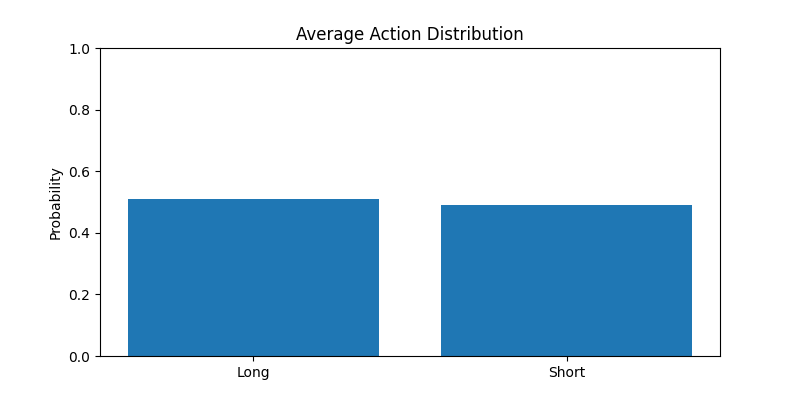

In [ ]:
display(Image(filename='evaluation/images/demo/action_distribution.png'))